In [1]:
import os
import sys
import ast
import json

import clip
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
from transformers import CLIPTokenizer, CLIPModel, CLIPProcessor

import seaborn as sns
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity

%matplotlib inline

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [3]:
class ArtDataset(Dataset):
    def __init__(self, root_dir, json_path, transform=None):
        """
        Args:
            root_dir (str): Path to the root directory containing subfolders like Cubism, Fauvism, etc.
            json_path (str): Path to the JSON file containing image labels/descriptions.
            transform (callable, optional): Optional transform to be applied on an image.
        """
        self.root_dir = root_dir
        self.transform = transform

        # Load the JSON file
        with open(json_path, "r") as f:
            self.image_descriptions = json.load(f)

        # Create a list of (image_path, description) pairs
        self.samples = []
        for rel_path, description in self.image_descriptions.items():
            full_path = os.path.join(self.root_dir, rel_path)
            if os.path.exists(full_path):  # Ensure the file exists
                self.samples.append((full_path, description))
            else:
                print(f"Warning: File not found - {full_path}")

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        # Load image
        img_path, description = self.samples[idx]
        image = Image.open(img_path).convert("RGB")

        # Apply transformation for normalized image
        if self.transform:
            normalized_image = self.transform(image)
        
        # Return both normalized and raw image
        return normalized_image, image, description

In [4]:
# Define preprocessing transforms
transform = transforms.Compose([
    transforms.Resize((256, 256)),  # Resize to 256x256
    transforms.ToTensor(),          # Convert to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Normalize
])

In [5]:
# Paths to your data
root_dir = "wikiart_subset"  # Path to the folder containing Cubism, Fauvism, etc.
json_path = "wikiart_subset/image_labels.json"

# Create dataset
dataset = ArtDataset(root_dir=root_dir, json_path=json_path, transform=transform)

# Test loading a sample
_, image, description = dataset[0]

print("Image shape:", _.shape)
print("Description:", description)

Image shape: torch.Size([3, 256, 256])
Description: An urban scene reimagined through fragmented perspectives and interlocking shapes.


In [6]:
dataset[0][0].shape

torch.Size([3, 256, 256])

In [7]:
def plot_tensor_image(image_tensor):
    """
    Plots a torch.float32 image tensor using Matplotlib.

    Args:
        image_tensor (torch.Tensor): The image tensor to plot. Should be of shape (C, H, W) or (H, W).
    """
    # Move tensor to CPU and convert to NumPy array
    image_np = image_tensor.cpu().numpy()

    # Remove channel dimension if it's 1 (grayscale image)
    if image_np.ndim == 3 and image_np.shape[0] == 1:
        image_np = image_np.squeeze(0)

    # Transpose if the channel dimension is not last (e.g., from (C, H, W) to (H, W, C))
    if image_np.ndim == 3 and image_np.shape[0] <= 3:
        image_np = image_np.transpose(1, 2, 0)

    # Plot the image
    plt.imshow(image_np, cmap='gray' if image_np.ndim == 2 else None)
    plt.axis('off')  # Turn off axis labels and ticks
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


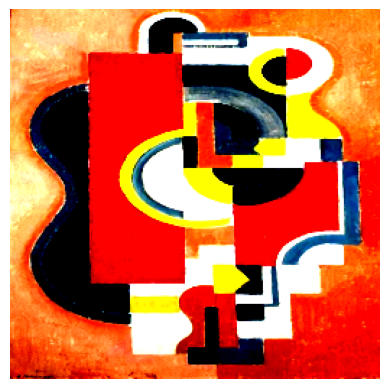

In [8]:
plot_tensor_image(_)

## Compute Embeddings

In [9]:
clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32").to(device)
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

D:\Python\pytorch\env\lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [10]:
processor

CLIPProcessor:
- image_processor: CLIPImageProcessor {
  "crop_size": {
    "height": 224,
    "width": 224
  },
  "do_center_crop": true,
  "do_convert_rgb": true,
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.48145466,
    0.4578275,
    0.40821073
  ],
  "image_processor_type": "CLIPImageProcessor",
  "image_std": [
    0.26862954,
    0.26130258,
    0.27577711
  ],
  "resample": 3,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "shortest_edge": 224
  }
}

- tokenizer: CLIPTokenizerFast(name_or_path='openai/clip-vit-base-patch32', vocab_size=49408, model_max_length=77, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<|startoftext|>', 'eos_token': '<|endoftext|>', 'unk_token': '<|endoftext|>', 'pad_token': '<|endoftext|>'}, clean_up_tokenization_spaces=True),  added_tokens_decoder={
	49406: AddedToken("<|startoftext|>", rstrip=False, lstrip=False, single_word=False, normalized=True, spe

In [11]:
image_path = "wikiart_subset/Cubism/Cubism-0.jpg"
description = "An urban scene reimagined through fragmented perspectives and interlocking shapes."

In [12]:
# Load and preprocess the image
image = Image.open(image_path).convert("RGB")

In [13]:
# Helper functions for encoding
def encode_image(image):
    inputs = processor(images=image, return_tensors="pt").to(device)
    with torch.no_grad():
        image_features = clip_model.get_image_features(**inputs)
    return image_features.cpu().numpy()

def encode_text(text):
    inputs = processor(text=text, return_tensors="pt", padding=True, truncation=True).to(device)
    with torch.no_grad():
        text_features = clip_model.get_text_features(**inputs)
    return text_features.cpu().numpy()

# Compute similarity matrix
def compute_similarity_matrix(dataset):
    image_embeddings = []
    text_embeddings = []

    for i in range(20): # len(dataset)
        _, raw_image, text = dataset[i]  # Use raw_image for CLIP
        image_embeddings.append(encode_image(raw_image))
        text_embeddings.append(encode_text(text))

    image_embeddings = np.vstack(image_embeddings)
    text_embeddings = np.vstack(text_embeddings)
    return cosine_similarity(image_embeddings, text_embeddings)

# Plot heatmap
def plot_similarity_heatmap(similarity_matrix, image_labels, text_labels):
    plt.figure(figsize=(10, 8))
    sns.heatmap(
        similarity_matrix,
        annot=True,
        fmt=".2f",
        cmap="YlGnBu",
        xticklabels=text_labels,
        yticklabels=image_labels,
        vmin=-1,
        vmax=1
    )
    plt.title("Image-Text Embedding Similarity")
    plt.xlabel("Text Prompts")
    plt.ylabel("Images")
    plt.show()


In [14]:
# Encode the image and text
image_embedding = encode_image(image)
text_embedding = encode_text(description)

D:\Python\pytorch\env\lib\site-packages\transformers\models\clip\modeling_clip.py:480: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at ..\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:263.)
  attn_output = torch.nn.functional.scaled_dot_product_attention(


In [15]:
print("Image embedding shape:", image_embedding.shape)
print("Text embedding shape:", text_embedding.shape)

Image embedding shape: (1, 512)
Text embedding shape: (1, 512)


## Visualize the heatmap

In [16]:
len(dataset.samples[:10])

10

(20, 20)


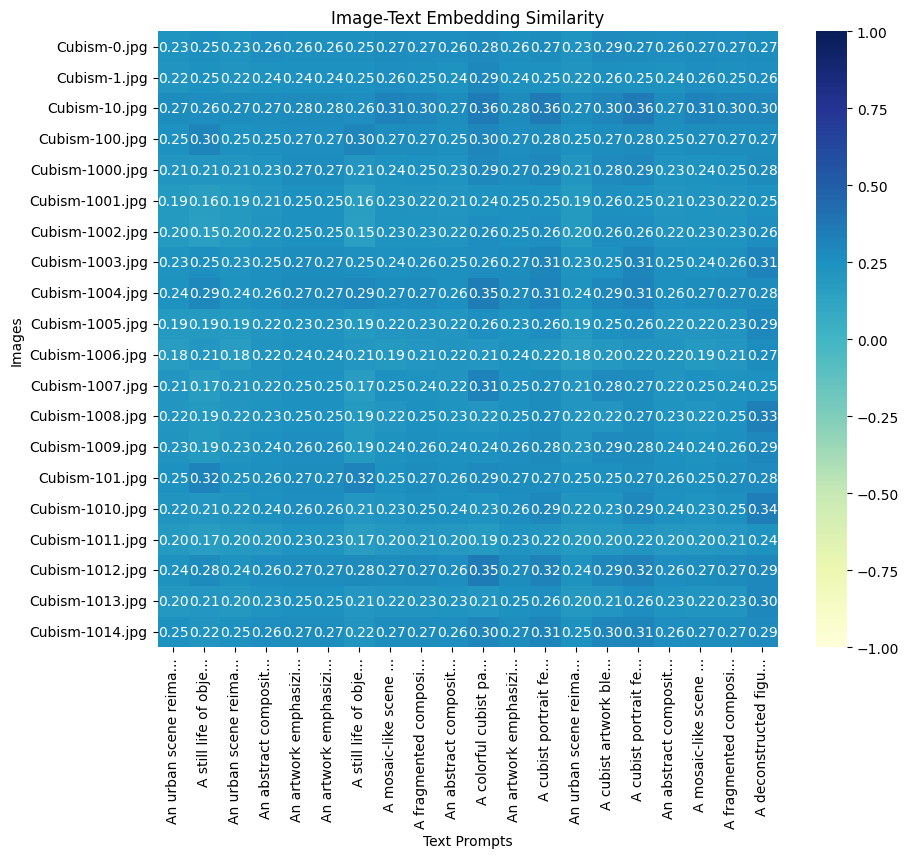

In [17]:
# Generate labels
image_labels = [os.path.basename(path) for path, _ in dataset.samples[:20]]
text_labels = [description[:20] + "..." for _, description in dataset.samples[:20]]

# Compute and plot similarity matrix
similarity_matrix = compute_similarity_matrix(dataset)
print(similarity_matrix.shape)
plot_similarity_heatmap(similarity_matrix, image_labels, text_labels)